# Initialization of hyperparameter values

In [1]:
# create toy model
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import elicit as el

from elicit.extras import utils

tfd = tfp.distributions

# numeric, standardized predictor
def std_predictor(N, quantiles):
    X = tf.cast(np.arange(N), tf.float32)
    X_std = (X-tf.reduce_mean(X))/tf.math.reduce_std(X)
    X_sel = tfp.stats.percentile(X_std, quantiles)
    return X_sel

# implemented, generative model
class ToyModel2:
    def __call__(self, prior_samples, design_matrix, **kwargs):
        B = prior_samples.shape[0]
        S = prior_samples.shape[1]

        # preprocess shape of design matrix
        X = tf.broadcast_to(design_matrix[None, None,:],
                           (B,S,len(design_matrix)))
        # linear predictor (= mu)
        epred = tf.add(prior_samples[:, :, 0][:,:,None],
                       tf.multiply(prior_samples[:, :, 1][:,:,None], X)
                       )
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        # selected observations
        y_X0, y_X1, y_X2 = (ypred[:,:,0], ypred[:,:,1], ypred[:,:,2])

        # log R2 (log for numerical stability)
        log_R2 = utils.log_R2(ypred, epred)

        return dict(
            likelihood=likelihood,
            ypred=ypred, epred=epred,
            prior_samples=prior_samples,
            y_X0=y_X0, y_X1=y_X1, y_X2=y_X2,
            log_R2=log_R2
        )

ground_truth = {
    "beta0": tfd.Normal(loc=5, scale=1),
    "beta1": tfd.Normal(loc=2, scale=1),
    "sigma": tfd.HalfNormal(scale=10.0),
}

eliobj = el.Elicit(
    model=el.model(
        obj=ToyModel2,
        design_matrix=std_predictor(N=200, quantiles=[25,50,75])
        ),
    parameters=[
        el.parameter(
            name="beta0",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu0"),
                scale=el.hyper("sigma0", lower=0)
                )
        ),
        el.parameter(
            name="beta1",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu1"),
                scale=el.hyper("sigma1", lower=0)
                )
        ),
        el.parameter(
            name="sigma",
            family=tfd.HalfNormal,
            hyperparams=dict(
                scale=el.hyper("sigma2", lower=0)
                )
        ),
    ],
    targets=[
        el.target(
            name=f"y_X{i}",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ) for i in range(3)
    ]+[
        el.target(
            name="log_R2",    
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        )
    ],
    expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    ),
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.1,
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="parametric_prior",
        seed=0,
        epochs=600
    ),
    initializer=el.initializer(
        hyperparams = dict(
            mu0=0., sigma0=el.utils.LowerBound(lower=0.).forward(0.3),
            mu1=1., sigma1=el.utils.LowerBound(lower=0.).forward(0.5),
            sigma2=el.utils.LowerBound(lower=0.).forward(0.4)
        )
    )
)

C:\Users\bockting\AppData\Roaming\Python\Python311\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
eliobj.fit()

Training


100%|██████████| 600/600 [03:17<00:00,  3.04it/s]


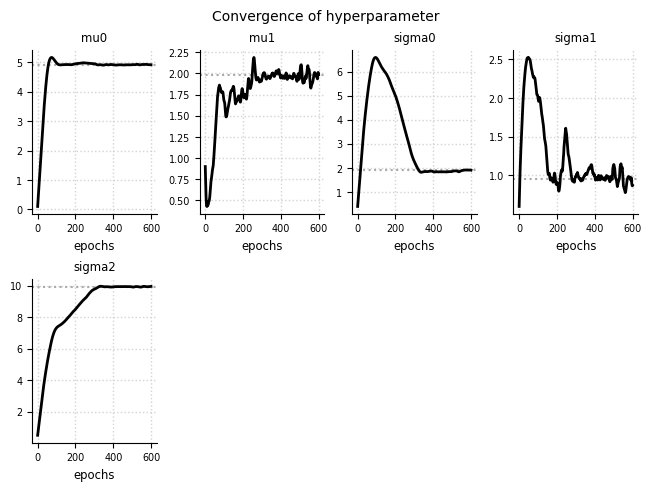

In [12]:
el.plots.hyperparameter(eliobj)

In [10]:
import copy

eliobj2 = copy.deepcopy(eliobj)

initializer_updated = el.initializer(
    method="sobol",
    loss_quantile=0,
    iterations=32,
    distribution=el.initialization.uniform(
        radius=10.,
        mean=0.
        )
)

eliobj2.update(initializer=initializer_updated)

INFO: Results have been reset.


In [11]:
eliobj2.fit()

Initialization


100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


 
Training


100%|██████████| 600/600 [03:46<00:00,  2.65it/s]


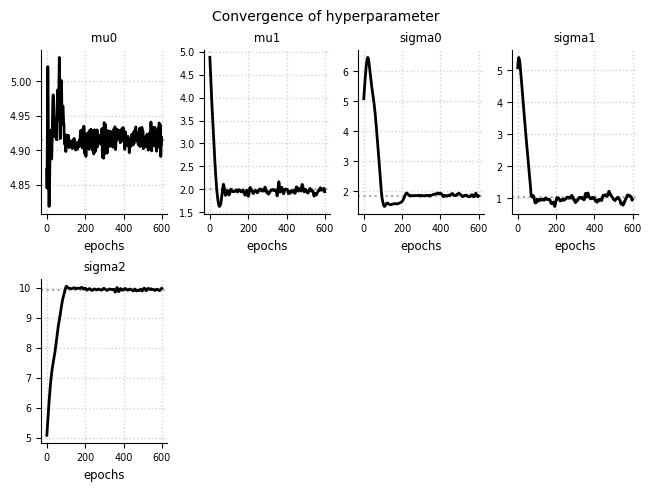

In [13]:
el.plots.hyperparameter(eliobj2)